***Задание 15. Решить задачу Коши для обыкновенного дифференциального уравнения первого порядка. Полученное численное решение сравнить с аналитическим решением. Определить погрешность решения. Написать программу для реализации явного и неявного методов решения ОДУ по общим таблицам Бутчера. В качестве тестовых примеров использовать предложенные схемы разного порядка***

In [45]:
import ctypes
import math
import matplotlib.pyplot as plt

# scheme = {
#     "c": [c0, c1, ..., cs-1],
#     "A": [[a00, a01, ..., a0s-1],
#           [a10, a11, ..., a1s-1],
#           ...
#           [as-1,0, ..., as-1,s-1]],
#     "b": [b0, b1, ..., bs-1],
# }

In [46]:


lib = ctypes.CDLL('../1_matrix/a.dll')

lib.create_matrix.restype = ctypes.c_void_p
lib.create_matrix.argtypes = (ctypes.c_int, ctypes.c_int, ctypes.POINTER(ctypes.c_double))
lib.matrix_solve_gauss.argtypes = (
    ctypes.c_void_p, 
    ctypes.POINTER(ctypes.c_double), 
    ctypes.POINTER(ctypes.c_double)
)

def cpp_matrix_create(rows, cols, data_2d):
    flat = [x for row in data_2d for x in row]
    arr = (ctypes.c_double * len(flat))(*flat)
    return lib.create_matrix(rows, cols, arr)

def cpp_matrix_solve_gauss(A_ptr, b):
    n = len(b)
    b_arr = (ctypes.c_double * n)(*b)
    res_arr = (ctypes.c_double * n)()
    lib.matrix_solve_gauss(A_ptr, b_arr, res_arr)
    return [res_arr[i] for i in range(n)]

In [47]:
def rk_explicit_step(f, x, y, h, scheme):
    c = scheme["c"]
    A = scheme["A"]
    b = scheme["b"]
    s = len(c)
    
    k = [0.0] * s
    for i in range(s):
        # y_i = y + sum{j=0}->{i-1} A[i][j] * k[j]
        y_i = y
        for j in range(i):
            y_i += A[i][j] * k[j]
        x_i = x + c[i] * h
        k[i] = f(x_i, y_i) * h
    
    # y_next = y + sum b_i * k_i
    y_next = y
    for i in range(s):
        y_next += b[i] * k[i]
    
    return y_next


def rk_implicit_step(f, x, y, h, scheme):
    c = scheme["c"]
    A = scheme["A"]
    b = scheme["b"]
    s = len(c)
    
    k = [0.0] * s
    for i in range(s):
        y_i = y
        for j in range(i):
            y_i += A[i][j] * k[j]
        x_i = x + c[i] * h
        k[i] = f(x_i, y_i) * h
    
    max_iter = 20
    tol = 1e-12
    for _ in range(max_iter):
        k_new = [0.0] * s
        converged = True
        
        for i in range(s):
            # y_i = y + sum_j A[i][j] * k[j]
            y_i = y
            for j in range(s):
                y_i += A[i][j] * k[j] 
            x_i = x + c[i] * h
            k_new[i] = f(x_i, y_i) * h
            
            if not abs(k[i] - k_new[i]) < tol:
                converged = False
        
        k = k_new
        if converged:
            break
    
    y_next = y
    for i in range(s):
        y_next += b[i] * k[i]
    
    return y_next


def solve_ode(f, x0, x1, y0, h, step_func, scheme=None):

    x = x0
    y = y0
    xs = [x]
    ys = [y]
    iter = 0
    while x < x1:
        if x + h > x1:
            h = x1 - x

        y_next = step_func(f, x, y, h, scheme)
        x += h
        y = y_next
        xs.append(x)
        ys.append(y)
        iter += 1
    
    return xs, ys, iter

In [83]:
# явные
# Метод Эйлера 1 порядок
euler_1 = {
    "c": [0.0],
    "A": [[0.0]],
    "b": [1.0]
}
# Метод Ральстона 2
ralston_2 = {
    "c": [0.0, 2/3],
    "A": [
        [0.0, 0.0],
        [2/3, 0.0]
    ],
    "b": [1/4, 3/4]
}
# Метод Хойна 3 
heun_3 = {
    "c": [0.0, 1/3, 2/3],
    "A": [
        [0.0, 0.0, 0.0],
        [1/3, 0.0, 0.0],
        [0.0, 2/3, 0.0]
    ],
    "b": [1/4, 0.0, 3/4]
}
# Правило 3/8 - 4
rk4_38 = {
    "c": [0.0, 1/3, 2/3, 1.0],
    "A": [
        [0.0, 0.0, 0.0, 0.0],
        [1/3, 0.0, 0.0, 0.0],
        [-1/3, 1.0, 0.0, 0.0],
        [1.0, -1.0, 1.0, 0.0]
    ],
    "b": [1/8, 3/8, 3/8, 1/8]
}
# Неявные методы
# Метод Радо-Эйлер 1
rado_euler_1 = {
    "c": [1.0],
    "A": [[1.0]],
    "b": [1.0]
}
# Метод Гаусса 2
gauss_2 = {
    "c": [0.5],
    "A": [[0.5]],
    "b": [1.0]
}
# Метод Радо 3
rado_3 = {
    "c": [1/3, 1.0],
    "A": [
        [5/12, -1/12],
        [3/4,  1/4]
    ],
    "b": [3/4, 1/4]
}
# Метод Гаусса 4
gauss_4 = {
    "c": [0.5 - math.sqrt(3) / 6, 0.5 + math.sqrt(3) / 6],
    "A": [
        [0.25, 0.25 - math.sqrt(3)/6],
        [0.25 + math.sqrt(3)/6, 0.25]
    ],
    "b": [0.5, 0.5]
}

methods = {
    "Эйлер (1-й порядок, явный)": (euler_1, 'explicit'),
    "Ральстон (2-й порядок, явный)": (ralston_2, 'explicit'),
    "Хойна (3-й порядок, явный)": (heun_3, 'explicit'),
    "Правило 3/8 (4-й порядок, явный)": (rk4_38, 'explicit'),
    "Радо-Эйлер (1-й порядок, неявный)": (rado_euler_1, 'implicit'),
    "Гаусс (2-й порядок, неявный)": (gauss_2, 'implicit'),
    "Радо (3-й порядок, неявный)": (rado_3, 'implicit'),
    "Гаусс (4-й порядок, неявный)": (gauss_4, 'implicit'),
}



In [90]:

def f_ode(x, y):
    return x + y

def f_ode(x, y):
    """Правая часть ОДУ: x y' - 2 y² ln x + y = 0 => y' = (2 y² ln x - y) / x"""
    if x == 0:
        raise ValueError("x не может быть 0")
    return (2 * y * y * math.log(x) - y) / x

def y_analytic(x):
    return 2 * math.exp(x) - x - 1

def y_analytic(x):
    """Аналитическое решение: y = 1 / (2 ln x + 2 + x)"""
    if x <= 0:
        raise ValueError("ln(x) не определён для x <= 0")
    denominator = 2 * math.log(x) + 2 + x
    if denominator == 0:
        raise ValueError("Знаменатель равен нулю")
    return 1.0 / denominator

# Параметры
x0, x1 = 1.0, 4.0
y0 = 0.3333
h = 0.2


all_solutions = {}

for name, (scheme, method_type) in methods.items():
    print("-" * 75)
    if method_type == 'explicit':
        x_num, y_num, _ = solve_ode(f_ode, x0, x1, y0, h, rk_explicit_step, scheme)
    else:
        x_num, y_num, _ = solve_ode(f_ode, x0, x1, y0, h, rk_implicit_step, scheme)
    
    y_true = [y_analytic(x) for x in x_num]
    max_err = max(abs(y_n - y_t) for y_n, y_t in zip(y_num, y_true))
    y_end_num = y_num[-1]
    y_end_true = y_true[-1]
    all_solutions[name] = {
        'x': x_num,
        'y': y_num,
        'type': method_type
    }
    print(f"{name:<35} | Ошибка: {max_err:.4e} | y_ode = {y_end_num:.6f}")


---------------------------------------------------------------------------
Эйлер (1-й порядок, явный)          | Ошибка: 2.2559e-02 | y_ode = 0.093597
---------------------------------------------------------------------------
Ральстон (2-й порядок, явный)       | Ошибка: 8.3878e-04 | y_ode = 0.114657
---------------------------------------------------------------------------
Хойна (3-й порядок, явный)          | Ошибка: 1.9292e-04 | y_ode = 0.113850
---------------------------------------------------------------------------
Правило 3/8 (4-й порядок, явный)    | Ошибка: 3.3333e-05 | y_ode = 0.113975
---------------------------------------------------------------------------
Радо-Эйлер (1-й порядок, неявный)   | Ошибка: 1.8894e-02 | y_ode = 0.132391
---------------------------------------------------------------------------
Гаусс (2-й порядок, неявный)        | Ошибка: 3.7970e-04 | y_ode = 0.114327
---------------------------------------------------------------------------
Радо (3-й по

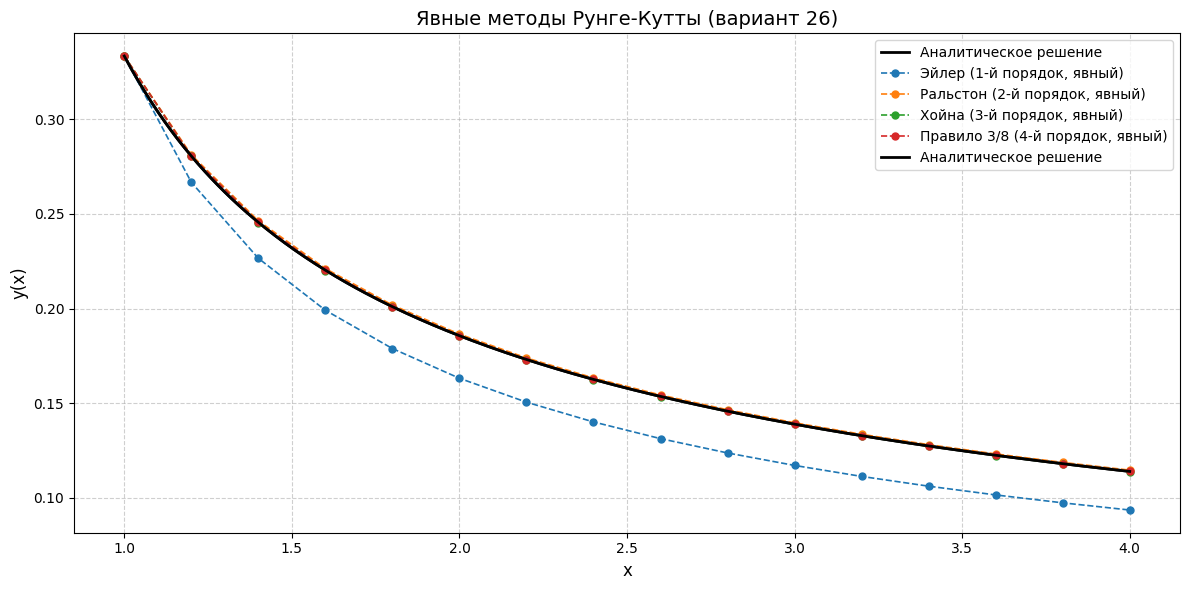

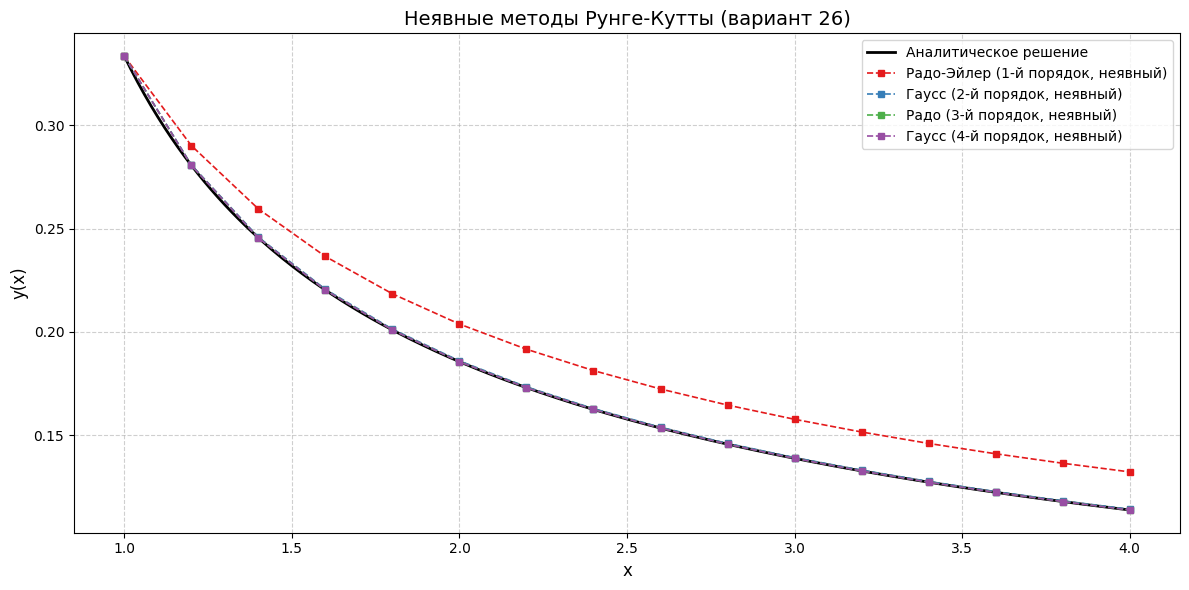

In [91]:
import matplotlib.pyplot as plt

x_fine = [1.0 + i * 0.01 for i in range(int((4.0 - 1.0) / 0.01) + 1)]
y_fine = [y_analytic(x) for x in x_fine]

# ЯВНЫЕ МЕТОДЫ
plt.figure(figsize=(12, 6))
plt.plot(x_fine, y_fine, 'k-', linewidth=2, label='Аналитическое решение')

colors_exp = plt.cm.tab10(range(10))  # цвета для явных
for idx, (name, data) in enumerate(all_solutions.items()):
    if data['type'] == 'explicit':
        plt.plot(
            data['x'], data['y'], 
            'o--', 
            color=colors_exp[idx % 10], 
            markersize=5, 
            linewidth=1.2,
            label=name
        )

plt.plot(x_fine, y_fine, 'k-', linewidth=2, label='Аналитическое решение')

plt.xlabel('x', fontsize=12)
plt.ylabel('y(x)', fontsize=12)
plt.title('Явные методы Рунге-Кутты (вариант 26)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# НЕЯВНЫЕ МЕТОДЫ
plt.figure(figsize=(12, 6))
plt.plot(x_fine, y_fine, 'k-', linewidth=2, label='Аналитическое решение')

colors_imp = plt.cm.Set1(range(9))
imp_idx = 0
for name, data in all_solutions.items():
    if data['type'] == 'implicit':
        plt.plot(
            data['x'], data['y'], 
            's--', 
            color=colors_imp[imp_idx % 9], 
            markersize=5, 
            linewidth=1.2,
            label=name
        )
        imp_idx += 1

plt.xlabel('x', fontsize=12)
plt.ylabel('y(x)', fontsize=12)
plt.title('Неявные методы Рунге-Кутты (вариант 26)', fontsize=14)
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()